In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

In [2]:
data = pd.read_csv('CNCnoise_1.csv', header=None)
data

,0
0,1911
1,1933
2,1901
3,1939
4,1914
...,...
634755,1913
634756,1915
634757,1914
634758,1914


In [3]:
data = data.rename(columns={0:'noise'})

In [4]:
data

,noise
0,1911
1,1933
2,1901
3,1939
4,1914
...,...
634755,1913
634756,1915
634757,1914
634758,1914


# 기본 소음 + 정상 소음 학습데이터 사용(100000개) + standard 스케일링

<Axes: >

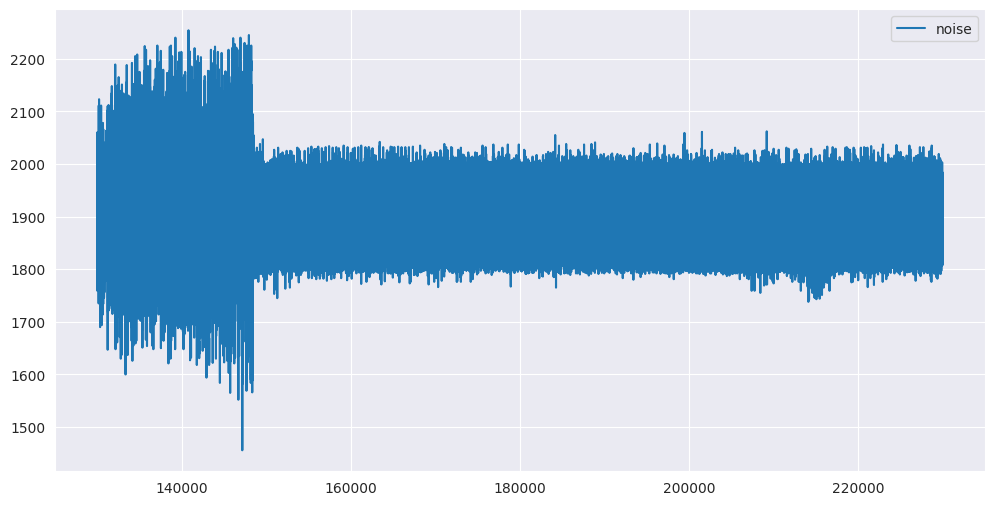

In [5]:
plt.figure(figsize=(12, 6))
sns.lineplot(data.iloc[130000:230000])

In [6]:
X_train, X_test = data.iloc[130000:230000], data.iloc[:130000]

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)

In [8]:
scaled_X_train = pd.DataFrame(scaled_X_train)
scaled_X_train

,0
0,-1.116572
1,-0.015190
2,2.654261
3,1.366204
4,1.310202
...,...
99995,-0.052525
99996,-0.015190
99997,0.003477
99998,-0.071193


In [9]:
scaled_X_test = scaler.transform(X_test)
scaled_X_test = pd.DataFrame(scaled_X_test)
scaled_X_test

,0
0,-0.127195
1,0.283490
2,-0.313870
3,0.395495
4,-0.071193
...,...
129995,0.824847
129996,1.384871
129997,-0.295202
129998,-1.993944


In [10]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector

timesteps = 20
features = 1

scaled_X_train = scaled_X_train.values.reshape((-1, timesteps, features))

# 인코더
inputs = Input(shape=(timesteps, features))
encoded = LSTM(64, activation='relu')(inputs)
encoded = RepeatVector(timesteps)(encoded)

# 디코더
decoded = LSTM(64, activation='relu', return_sequences=True)(encoded)
decoded = LSTM(features, activation='linear', return_sequences=True)(decoded)

# 오토인코더 모델
autoencoder = Model(inputs, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(scaled_X_train, scaled_X_train, epochs=40, batch_size=20, validation_split=0.1)

Epoch 1/40
225/225 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.9228 - val_loss: 0.4246
Epoch 2/40
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.7721 - val_loss: 0.4161
Epoch 3/40
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.7636 - val_loss: 0.3783
Epoch 4/40
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.6536 - val_loss: 0.3647
Epoch 5/40
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.6246 - val_loss: 0.2644
Epoch 6/40
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.5012 - val_loss: 0.1776
Epoch 7/40
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.4094 - val_loss: 0.1153
Epoch 8/40
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.3682 - val_loss: 0.0992
Epoch 9/40
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.3659 - val_loss: 0.0892
Epoch 10/40
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.3316 - val_loss: 0.0685
Epoch 11/40
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.3219 - val_loss: 0.0629
Epoch 12/40
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/

204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


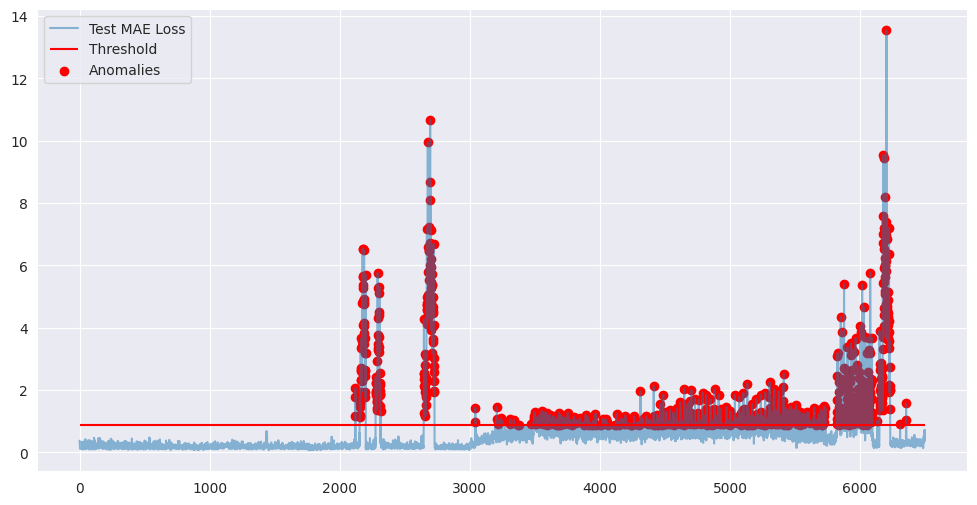

In [19]:
# 테스트 데이터 재구성

X_test_mae = scaled_X_test.values.reshape((-1, timesteps, features))

# 임계치(threshold) 설정 (예: 학습 데이터 재구성 오차 평균 + 표준편차)
X_train_pred = autoencoder.predict(X_test_mae)
train_mae_loss = np.mean(np.abs(X_train_pred - X_test_mae), axis=(1,2))
threshold = np.mean(train_mae_loss) + 0.3 * np.std(train_mae_loss)

# 이상치 판별
anomalies = train_mae_loss > threshold


# 결과 시각화
plt.figure(figsize=(12,6))
plt.plot(train_mae_loss, label='Test MAE Loss', alpha=0.5)
plt.hlines(threshold, xmin=0, xmax=len(train_mae_loss), colors='r', label='Threshold')
plt.scatter(np.where(anomalies)[0], train_mae_loss[anomalies], color='red', label='Anomalies')
# plt.yscale('log')
plt.legend()
plt.show()


=== Filtered Anomaly Detection Performance (based on filtered_anomalies) ===
              precision    recall  f1-score   support

      Normal       0.99      0.97      0.98      6145
     Anomaly       0.60      0.89      0.72       355

    accuracy                           0.96      6500
   macro avg       0.80      0.93      0.85      6500
weighted avg       0.97      0.96      0.97      6500

ROC-AUC: 0.9295
PR-AUC (Average Precision): 0.5440


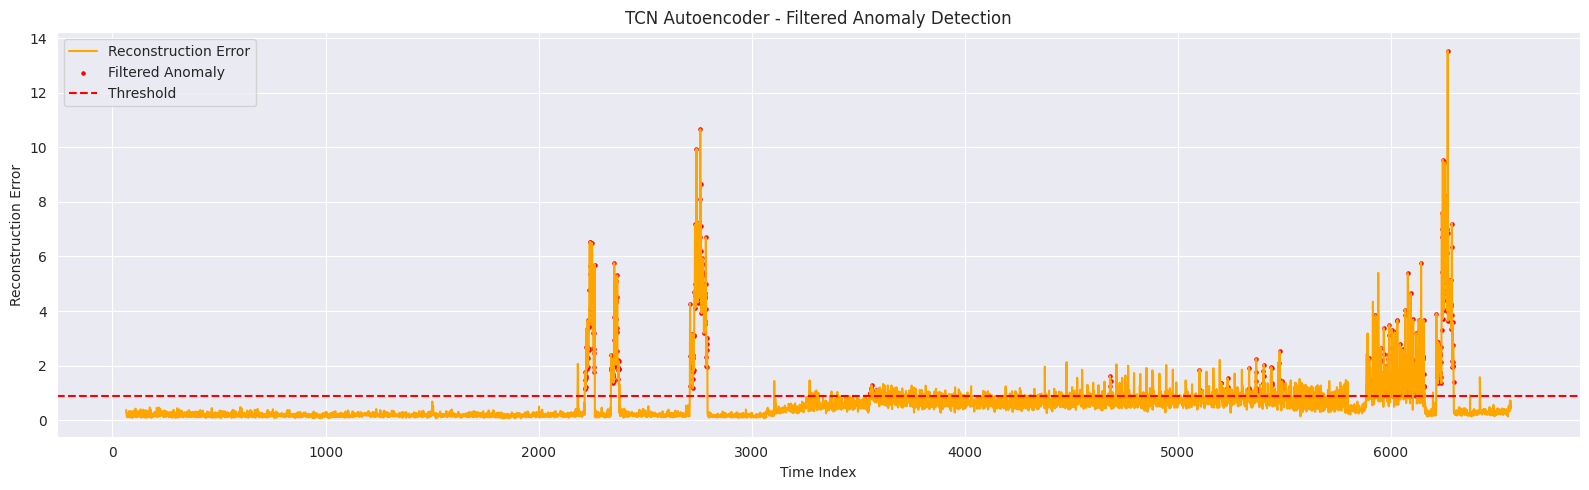

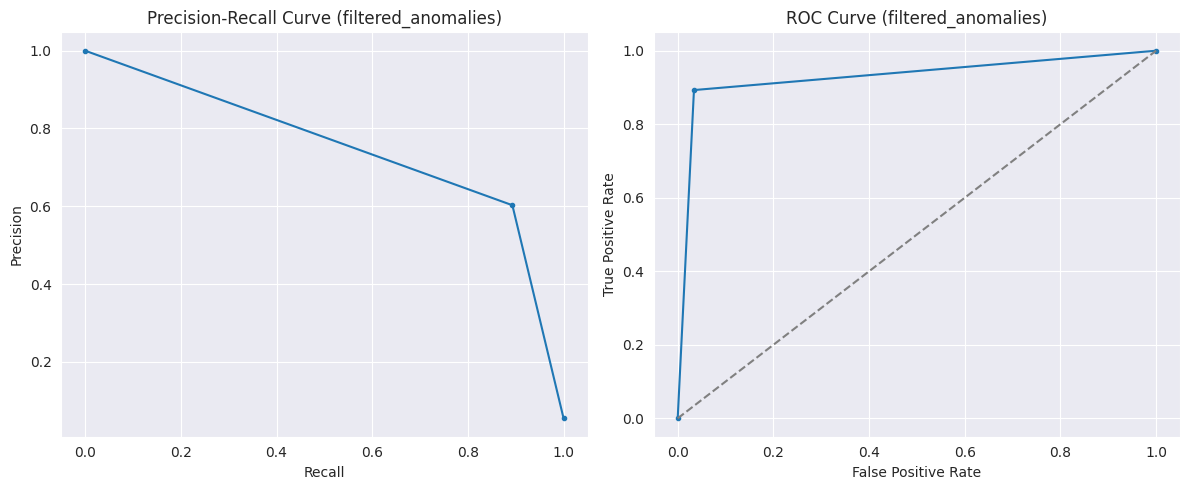

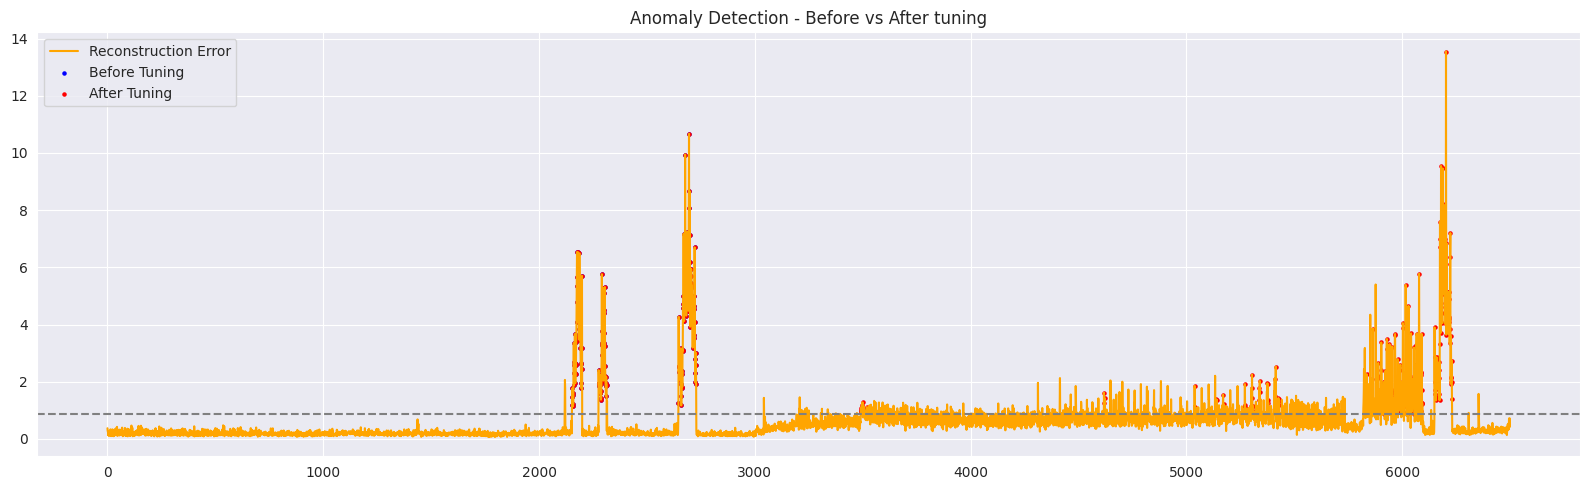

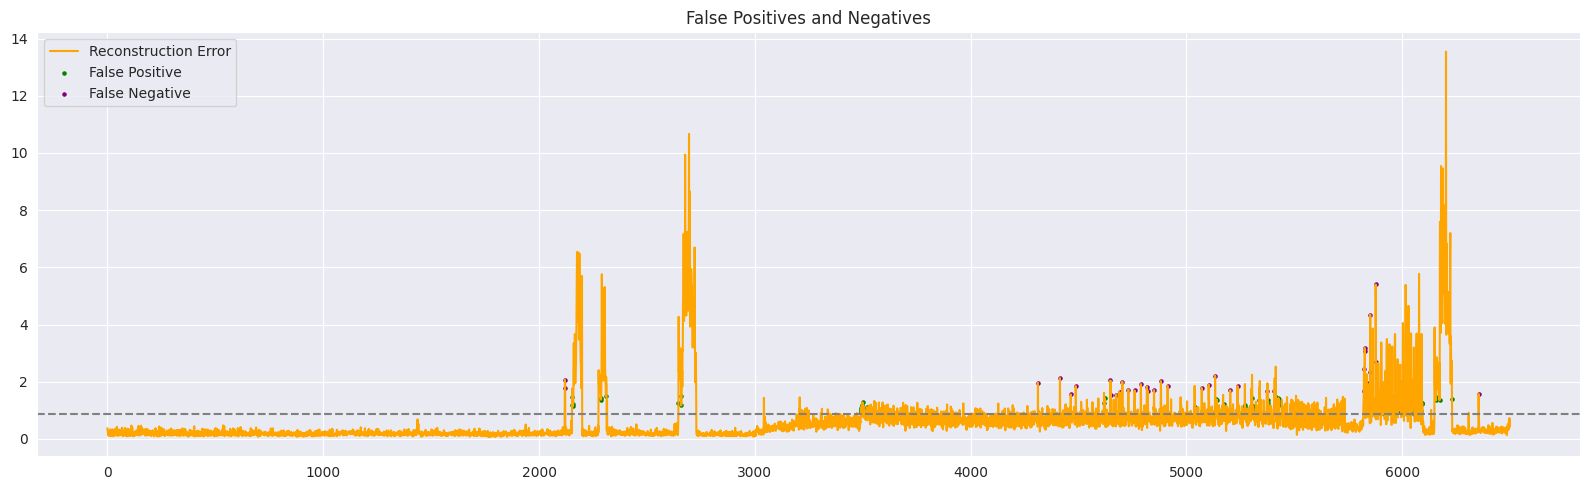

[탐지 구간 수 비교] 이전: 3, 현재: 43


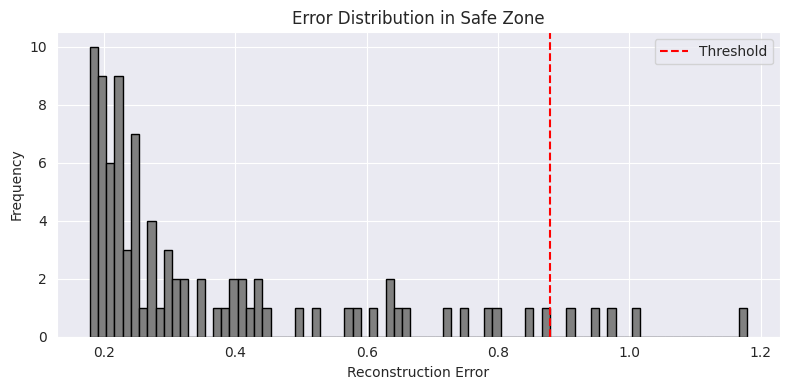

In [20]:
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, precision_recall_curve, roc_curve

# =====================
# 평가 지표 (filtered_anomalies 기준으로 평가)
# =====================
seq_len = 64
from scipy.ndimage import label

# === 조건 기반 이상 탐지 ===
is_over_threshold = train_mae_loss > threshold
labeled, num_features = label(is_over_threshold)
test_errors = np.array(train_mae_loss)

# === 필터링 조건 설정 ===
min_len = 5          # 조정 가능
min_std = 0.002      # 조정 가능
min_range = 0.004    # 조정 가능

# === 필터링된 이상 마스크 초기화 ===
filtered_anomalies = np.zeros_like(test_errors, dtype=int)

# === 필터링 루프 ===
for i in range(1, num_features + 1):
    indices = np.where(labeled == i)[0]
    if len(indices) >= min_len:
        segment = test_errors[indices]
        if (np.std(segment) >= min_std) or (np.max(segment) - np.min(segment) >= min_range):
            filtered_anomalies[indices] = 1

# === 기본 pseudo-label 생성 (Z + IQR 기반) ===
z_scores = (test_errors - np.mean(test_errors)) / np.std(test_errors)
z_mask = np.abs(z_scores) > 3
Q1 = np.percentile(test_errors, 25)
Q3 = np.percentile(test_errors, 75)
IQR = Q3 - Q1
iqr_mask = (test_errors < Q1 - 1.5 * IQR) | (test_errors > Q3 + 1.5 * IQR)
pseudo_labels = (z_mask | iqr_mask).astype(int)

# === 완화 조건 적용 ===
from scipy.ndimage import uniform_filter1d

smooth_errors = uniform_filter1d(test_errors, size=30)
gradients = np.abs(np.gradient(smooth_errors))

safe_zone_mask = (
    (test_errors > threshold * 0.2) &  # ← 범위 확대
    (test_errors < threshold * 1.4) &
    (gradients < 0.0001)               # ← gradient 제한 완화
)

pseudo_labels[safe_zone_mask] = 0
filtered_anomalies[safe_zone_mask] = 0

# === 핵심 변경 ===
print("\n=== Filtered Anomaly Detection Performance (based on filtered_anomalies) ===")
print(classification_report(pseudo_labels, filtered_anomalies, target_names=["Normal", "Anomaly"]))

roc_auc = roc_auc_score(pseudo_labels, filtered_anomalies)
ap_score = average_precision_score(pseudo_labels, filtered_anomalies)
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"PR-AUC (Average Precision): {ap_score:.4f}")

# =====================
# 시각화 (Error + Anomaly 위치 표시)
# =====================
positions = np.arange(seq_len, seq_len + len(test_errors))

plt.figure(figsize=(16, 5))
plt.plot(positions, test_errors, label="Reconstruction Error", color='orange')
plt.scatter(positions[filtered_anomalies == 1], test_errors[filtered_anomalies == 1], color='red', s=5, label='Filtered Anomaly')
plt.axhline(threshold, color='red', linestyle='--', label='Threshold')
plt.title("TCN Autoencoder - Filtered Anomaly Detection")
plt.xlabel("Time Index")
plt.ylabel("Reconstruction Error")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# =====================
# PR Curve & ROC Curve (Filtered 결과 기반)
# =====================
precision, recall, _ = precision_recall_curve(pseudo_labels, filtered_anomalies)
fpr, tpr, _ = roc_curve(pseudo_labels, filtered_anomalies)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(recall, precision, marker='.')
plt.title('Precision-Recall Curve (filtered_anomalies)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, marker='.')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('ROC Curve (filtered_anomalies)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

plt.tight_layout()
plt.show()


# =====================
# 검증 시각화 ①: 탐지 전후 비교
# =====================
# (이전 필터 결과 prev_filtered 예시로 생성)
prev_filtered = np.zeros_like(filtered_anomalies)
prev_filtered[:len(filtered_anomalies) // 2] = filtered_anomalies[:len(filtered_anomalies) // 2]

positions = np.arange(len(test_errors))
plt.figure(figsize=(16, 5))
plt.plot(positions, test_errors, label="Reconstruction Error", color="orange")
plt.scatter(np.where(prev_filtered == 1), test_errors[prev_filtered == 1], label="Before Tuning", s=5, color="blue")
plt.scatter(np.where(filtered_anomalies == 1), test_errors[filtered_anomalies == 1], label="After Tuning", s=5, color="red")
plt.axhline(threshold, linestyle="--", color="gray")
plt.legend()
plt.title("Anomaly Detection - Before vs After tuning")
plt.grid(True)
plt.tight_layout()
plt.show()

# =====================
# 검증 시각화 ②: FP / FN 위치
# =====================
false_positives = (filtered_anomalies == 1) & (pseudo_labels == 0)
false_negatives = (filtered_anomalies == 0) & (pseudo_labels == 1)

plt.figure(figsize=(16, 5))
plt.plot(test_errors, label='Reconstruction Error', color='orange')
plt.scatter(np.where(false_positives)[0], test_errors[false_positives], color='green', label='False Positive', s=5)
plt.scatter(np.where(false_negatives)[0], test_errors[false_negatives], color='purple', label='False Negative', s=5)
plt.axhline(threshold, linestyle='--', color='gray')
plt.legend()
plt.title("False Positives and Negatives")
plt.grid(True)
plt.tight_layout()
plt.show()

# =====================
# 검증 시각화 ③: 이상 탐지 구간 수 비교
# =====================
labeled_prev, num_prev = label(prev_filtered)
labeled_new, num_new = label(filtered_anomalies)
print(f"[탐지 구간 수 비교] 이전: {num_prev}, 현재: {num_new}")

# =====================
# 검증 시각화 ④: Safe Zone 내부 분포
# =====================
plt.figure(figsize=(8, 4))
plt.hist(test_errors[safe_zone_mask], bins=80, color='gray', edgecolor='black')
plt.axvline(threshold, color='red', linestyle='--', label="Threshold")
plt.title("Error Distribution in Safe Zone")
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



=== Filtered Anomaly Detection Performance (based on filtered_anomalies) ===
              precision    recall  f1-score   support

      Normal       0.99      0.97      0.98      6145
     Anomaly       0.60      0.89      0.72       355

    accuracy                           0.96      6500
   macro avg       0.80      0.93      0.85      6500
weighted avg       0.97      0.96      0.97      6500

ROC-AUC: 0.9295
PR-AUC (Average Precision): 0.5440


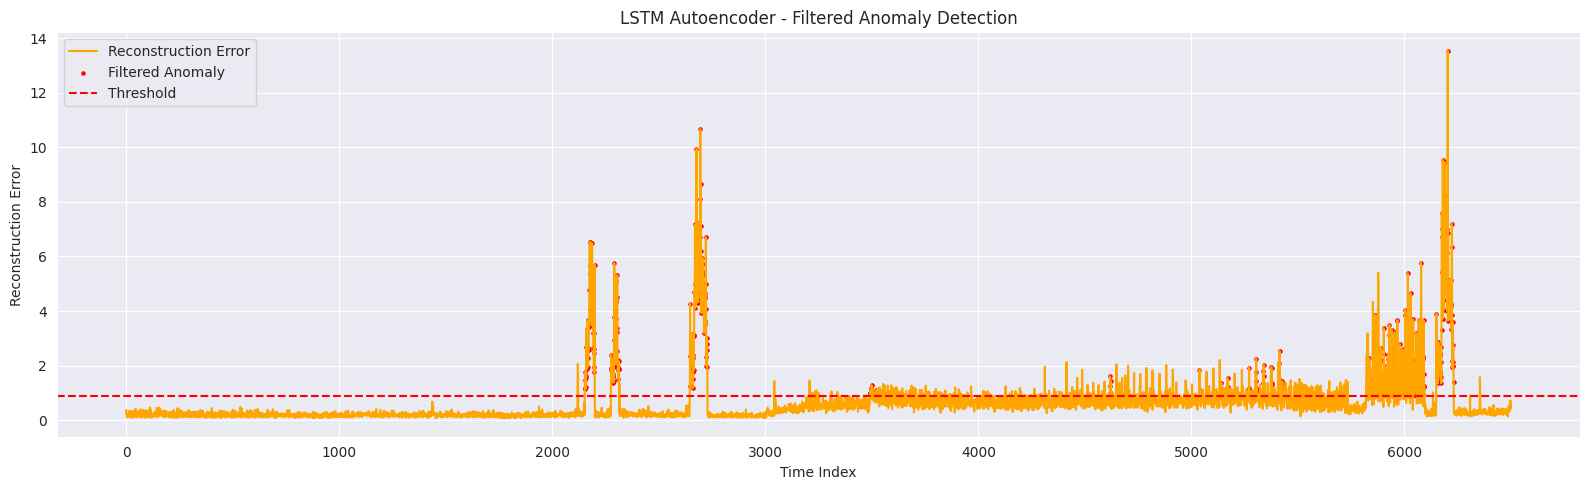

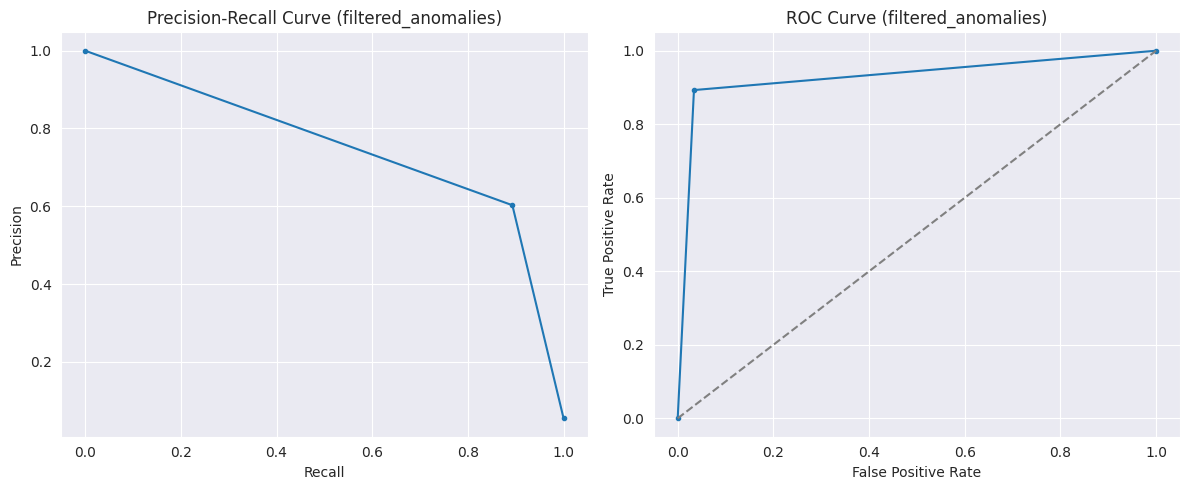

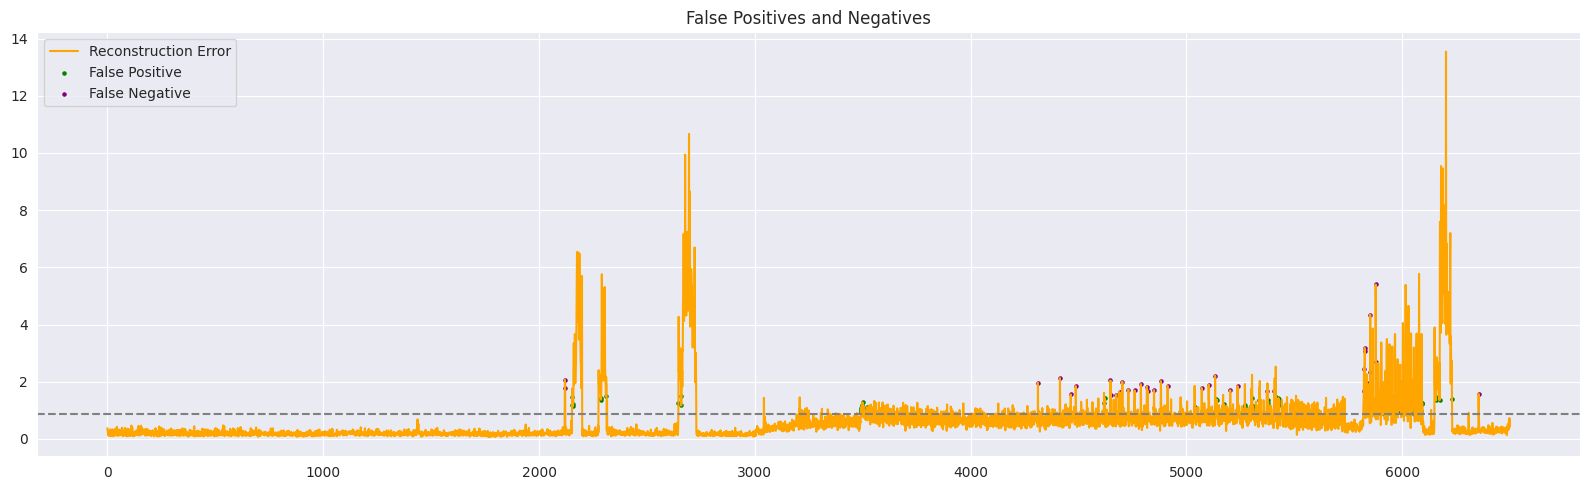

[탐지 구간 수 비교] 이전: 3, 현재: 43


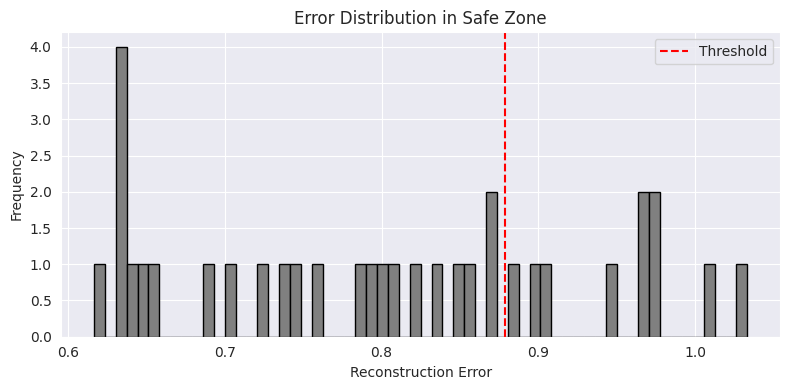

In [13]:
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, precision_recall_curve, roc_curve
from scipy.ndimage import label, uniform_filter1d

# === Reconstruction Error 기준 이상 여부 ===
test_errors = train_mae_loss.copy()  # (sample, )
is_over_threshold = test_errors > threshold
labeled, num_features = label(is_over_threshold)

# === 조건 기반 필터링 ===
min_len = 5
min_std = 0.001
min_range = 0.002
filtered_anomalies = np.zeros_like(test_errors, dtype=int)

for i in range(1, num_features + 1):
    indices = np.where(labeled == i)[0]
    if len(indices) >= min_len:
        segment = test_errors[indices]
        if (np.std(segment) >= min_std) or (np.max(segment) - np.min(segment) >= min_range):
            filtered_anomalies[indices] = 1

# === Pseudo-label (Z + IQR 기반) ===
z_scores = (test_errors - np.mean(test_errors)) / np.std(test_errors)
z_mask = np.abs(z_scores) > 3
Q1 = np.percentile(test_errors, 25)
Q3 = np.percentile(test_errors, 75)
IQR = Q3 - Q1
iqr_mask = (test_errors < Q1 - 1.5 * IQR) | (test_errors > Q3 + 1.5 * IQR)
pseudo_labels = (z_mask | iqr_mask).astype(int)

# === Safe zone 완화 조건 적용 ===
smooth_errors = uniform_filter1d(test_errors, size=30)
gradients = np.abs(np.gradient(smooth_errors))

safe_zone_mask = (
    (test_errors > threshold * 0.7) &
    (test_errors < threshold * 1.3) &
    (gradients < 0.0002)
)

pseudo_labels[safe_zone_mask] = 0
filtered_anomalies[safe_zone_mask] = 0

# === 성능 지표 출력 ===
print("\n=== Filtered Anomaly Detection Performance (based on filtered_anomalies) ===")
print(classification_report(pseudo_labels, filtered_anomalies, target_names=["Normal", "Anomaly"]))
print(f"ROC-AUC: {roc_auc_score(pseudo_labels, filtered_anomalies):.4f}")
print(f"PR-AUC (Average Precision): {average_precision_score(pseudo_labels, filtered_anomalies):.4f}")

# === 시각화 ①: 에러 + 이상 탐지 결과 ===
plt.figure(figsize=(16, 5))
plt.plot(test_errors, label="Reconstruction Error", color='orange')
plt.scatter(np.where(filtered_anomalies == 1)[0], test_errors[filtered_anomalies == 1], color='red', s=5, label='Filtered Anomaly')
plt.axhline(threshold, color='red', linestyle='--', label='Threshold')
plt.title("LSTM Autoencoder - Filtered Anomaly Detection")
plt.xlabel("Time Index")
plt.ylabel("Reconstruction Error")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === 시각화 ②: PR & ROC Curve ===
precision, recall, _ = precision_recall_curve(pseudo_labels, filtered_anomalies)
fpr, tpr, _ = roc_curve(pseudo_labels, filtered_anomalies)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(recall, precision, marker='.')
plt.title('Precision-Recall Curve (filtered_anomalies)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, marker='.')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('ROC Curve (filtered_anomalies)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.tight_layout()
plt.show()

# === 시각화 ③: FP/FN 분포
false_positives = (filtered_anomalies == 1) & (pseudo_labels == 0)
false_negatives = (filtered_anomalies == 0) & (pseudo_labels == 1)

plt.figure(figsize=(16, 5))
plt.plot(test_errors, label='Reconstruction Error', color='orange')
plt.scatter(np.where(false_positives)[0], test_errors[false_positives], color='green', label='False Positive', s=5)
plt.scatter(np.where(false_negatives)[0], test_errors[false_negatives], color='purple', label='False Negative', s=5)
plt.axhline(threshold, linestyle='--', color='gray')
plt.legend()
plt.title("False Positives and Negatives")
plt.grid(True)
plt.tight_layout()
plt.show()

# === 시각화 ④: 탐지 구간 수 비교
prev_filtered = np.zeros_like(filtered_anomalies)
prev_filtered[:len(filtered_anomalies) // 2] = filtered_anomalies[:len(filtered_anomalies) // 2]
labeled_prev, num_prev = label(prev_filtered)
labeled_new, num_new = label(filtered_anomalies)
print(f"[탐지 구간 수 비교] 이전: {num_prev}, 현재: {num_new}")

# === 시각화 ⑤: Safe Zone 내 에러 분포
plt.figure(figsize=(8, 4))
plt.hist(test_errors[safe_zone_mask], bins=60, color='gray', edgecolor='black')
plt.axvline(threshold, color='red', linestyle='--', label="Threshold")
plt.title("Error Distribution in Safe Zone")
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


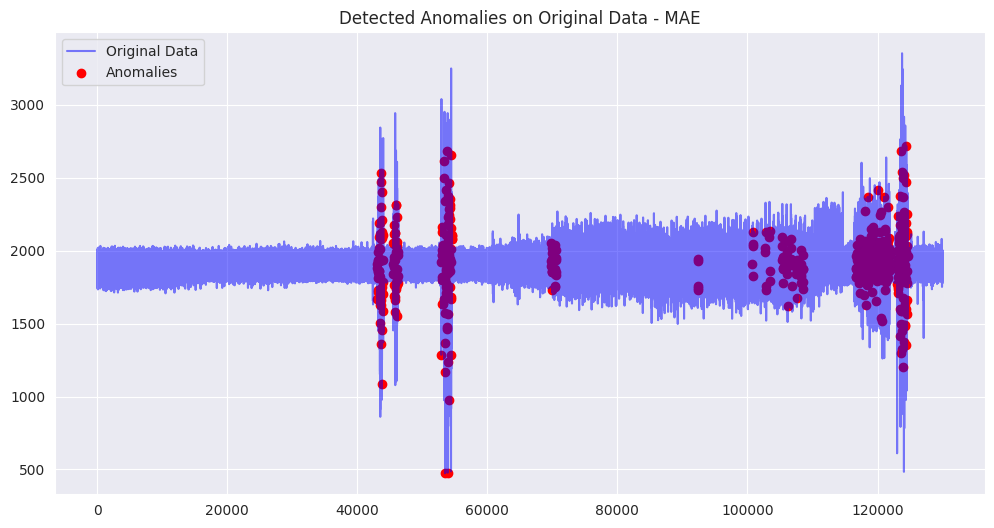

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# 원본 시계열 데이터 (예시: 1차원 시계열)
# 예: df['value'] 또는 value_array
original_values = data[:130000]['noise'].values  # 또는 value_array

# test_mae_loss와 anomalies는 이미 계산되어 있다고 가정
# test_mae_loss: 각 시퀀스별 이상치 점수 (길이: n_seq)
# anomalies: test_mae_loss > threshold (True/False, 길이: n_seq)

# 시퀀스별로 이상치가 감지된 인덱스 추출
anomaly_seq_indices = np.where(filtered_anomalies)[0]
# anomaly_seq_indices = np.where(anomalies)[0]

# 시퀀스의 시작 인덱스를 원본 데이터 인덱스로 변환
# 예를 들어, 시퀀스 길이가 timesteps라면, 각 시퀀스의 첫 번째 인덱스에 매핑
anomaly_data_indices = anomaly_seq_indices * timesteps

# 원본 데이터 시각화
plt.figure(figsize=(12,6))
plt.plot(original_values, label='Original Data', color='blue', alpha=0.5)

# 이상치 구간에 빨간 점 표시
plt.scatter(anomaly_data_indices, original_values[anomaly_data_indices], color='red', label='Anomalies')

plt.legend()
plt.title('Detected Anomalies on Original Data - MAE')
plt.show()